[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/05_the_many_variables_and_the_spurious_waffles.ipynb)

# Chapter 5 - The Many Variables & The Spurious Waffles

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install --upgrade daft
  !pip install causalgraphicalmodels
  !pip install watermark
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization 
import daft
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas,daft,causalgraphicalmodels

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5
daft                  : 0.1.2
causalgraphicalmodels : 0.0.4



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

In [6]:
### Tensorflow MCMC sampling helpers


In [7]:
USE_XLA = False              #@param
NUMBER_OF_CHAINS  = 2        #@param 
NUMBER_OF_BURNIN  = 500      #@param
NUMBER_OF_SAMPLES = 500      #@param
NUMBER_OF_LEAPFROG_STEPS = 4 #@param

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: v.numpy()
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data,
    )

@tf.function(autograph=False, experimental_compile=USE_XLA)
def run_hmc_chain(init_state,
              bijectors, 
              step_size, 
              target_log_prob_fn, 
              num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
              num_samples=NUMBER_OF_SAMPLES,
              burnin=NUMBER_OF_BURNIN,
              ):    

    def _trace_fn_transitioned(_, pkr):
        return (
            pkr.inner_results.inner_results.log_accept_ratio
        )

    hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn,
                    num_leapfrog_steps=num_leapfrog_steps,
                    step_size=step_size)         

    inner_kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel=hmc_kernel,
        bijector=bijectors)       

    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel=inner_kernel,
        target_accept_prob=.8,
        num_adaptation_steps=int(0.8*burnin),
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )    

    results, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=kernel,
        trace_fn=_trace_fn_transitioned)

    return results, sampler_stat    

def sample_posterior(jdc, 
              observed_data, 
              params, 
              init_state=None, 
              bijectors=None, 
              step_size = 0.1,
              num_chains=NUMBER_OF_CHAINS,                  
              num_samples=NUMBER_OF_SAMPLES, 
              burnin=NUMBER_OF_BURNIN):
        
    if init_state is None:
        init_state = list(jdc.sample(num_chains)[:-1])

    if bijectors is None:
        bijectors = [tfb.Identity() for i in init_state]

    target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)  

    results, sample_stats = run_hmc_chain(init_state,
                                  bijectors,
                                  step_size=step_size,
                                  target_log_prob_fn=target_log_prob_fn,                                      
                                  num_samples=num_samples, 
                                  burnin=burnin)

    stat_names = ['mean_tree_accept']
    sampler_stats = dict(zip(stat_names, [sample_stats]))      
        
    transposed_results = []
    
    for r in results:        
        if len(r.shape) == 2:
            transposed_shape = [1,0]
        elif len(r.shape) == 3:
            transposed_shape = [1,0,2] 
        else:
            transposed_shape = [1,0,2,3] 
        
        transposed_results.append(tf.transpose(r, transposed_shape))

    posterior = dict(zip(params, transposed_results))        

    az_trace = _trace_to_arviz(trace=posterior, 
                           sample_stats=sampler_stats)

    return posterior, az_trace

In [8]:
### Dataset URLs & Utils

In [9]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"

WAFFLE_DIVORCE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"
MILK_DATASET_PATH = f"{_BASE_URL}/milk.csv"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"

In [10]:
# A utility method to convert data (columns) from pandas dataframe
# into tensors with appropriate type
def df_to_tensors(name, df, columns, default_type=tf.float32):
    """ name : Name of the dataset
        df : pandas dataframe
        colums : a list of names that have the same type or
                 a dictionary where keys are the column names and values are the tensorflow type (e.g. tf.float32)
    """
    if isinstance(columns,dict):
        column_names = columns.keys()
        fields = [tf.cast(df[k].values, dtype=v) for k,v in columns.items()]    
    else:
        column_names = columns        
        fields = [tf.cast(df[k].values, dtype=default_type) for k in column_names]    
        
    # build the cls
    tuple_cls = collections.namedtuple(name, column_names)    
    # build the obj
    return tuple_cls._make(fields)

## 5.1 Spurious association

##### Code 5.1

The chapter is going to use 2 predictor variables - Marriage Rate & Median Age at Marriage to predict the divorce rate. Here we start with the first predictor variable - Median Age at Marriage

Loading the dataset and standardizing the variables of interest (i.e. median age at marriage and divorce rate)

In [11]:
d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())

##### Code 5.2

Here is the description of the linear regression model that use Median Age as the predictor variable.

$D_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_AA_i$   

$\alpha \sim Normal(0,0.2)$       

$\beta_A \sim Normal(0,0.5)$          

$\sigma \sim Exponential(1)$ 


We have standardized both D and A this means that the intercept ($\alpha$) should be close to zero. 

A slope ($\beta_A$) of 1 would then imply that a change in one standard deviation in marriage rate is associated with change of one standard deviation in divorce. 

Below we compute the standard deviation in median age

In [12]:
d.MedianAgeMarriage.std()

1.2436303013880823

This means that when $\beta_A$ is 1 then we expect a change of 1.2 years in median age at marriage is associated with 1 full standard deviation of the divorce rate. 

##### Code 5.3

Define the model and compute the posterior

In [13]:
tdf = df_to_tensors('WaffleDivorce', d, ['A', 'D'])

def model_5_1(median_age_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_1 = model_5_1(tdf.A)

posterior_5_1, trace_5_1 = sample_posterior(
                                jdc_5_1, 
                                observed_data=(tdf.D, ), 
                                bijectors=[tfb.Identity(), tfb.Identity(), tfb.Exp()],
                                params=['alpha', 'betaA', 'sigma'])

##### Code 5.4

Before we do posterior analysis let's check our priors

In [14]:
# Below we are using the value of A (median age) 
A = tf.constant([-2,2], dtype=tf.float32)
jdc_5_1_prior = model_5_1(A)
prior_pred_samples = jdc_5_1_prior.sample(1000)

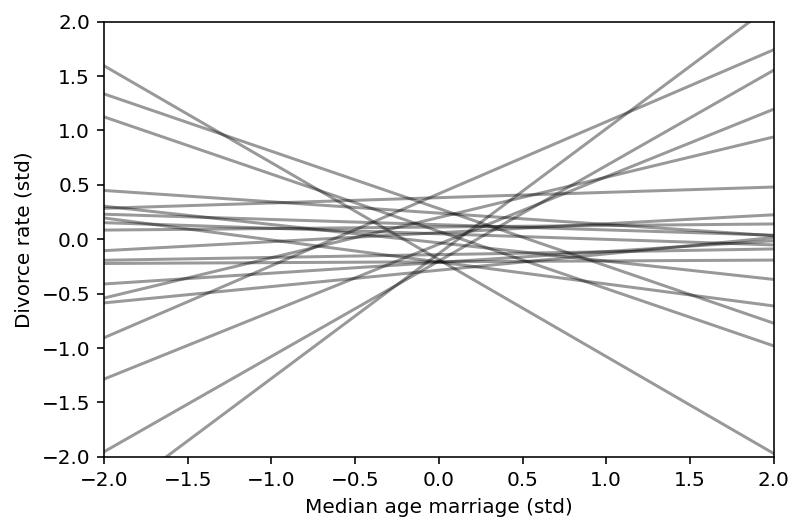

In [15]:
prior_alpha = prior_pred_samples[0]
prior_beta  = prior_pred_samples[1]
prior_sigma = prior_pred_samples[2]

ds, samples = jdc_5_1_prior.sample_distributions(value=[
    prior_alpha,
    prior_beta,
    prior_sigma,
    None
])

mu = ds[-1].distribution.loc

plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)
    
plt.xlabel("Median age marriage (std)")
plt.ylabel("Divorce rate (std)");

##### Code 5.5

Now for the posterior predictions.

In [16]:
sample_alpha = posterior_5_1["alpha"][0]
sample_betaA = posterior_5_1["betaA"][0]
sample_sigma = posterior_5_1["sigma"][0]

A_seq = tf.linspace(start=-3., stop=3.2, num=30)
A_seq = tf.cast(A_seq, dtype=tf.float32)

# we are creating a new model for the test values
jdc_5_1_test = model_5_1(A_seq)

# we will sample it using the trace_5_1
ds, samples = jdc_5_1_test.sample_distributions(value=[
    sample_alpha,
    sample_betaA,
    sample_sigma,
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

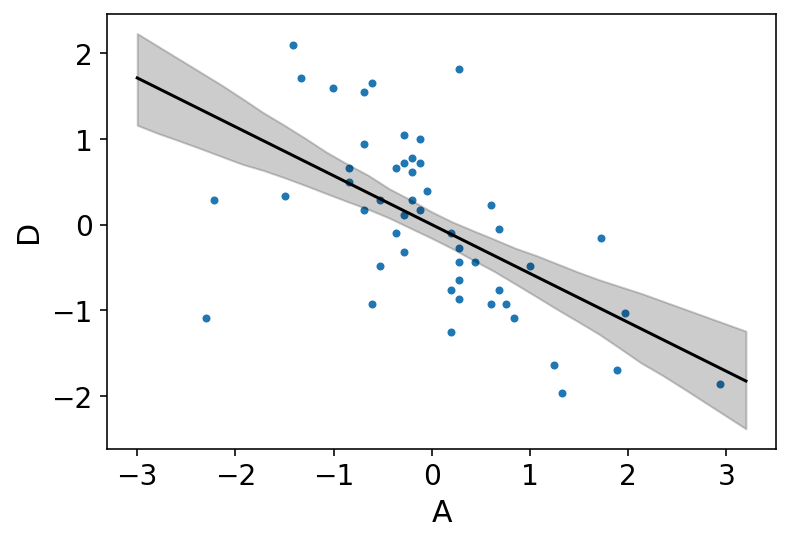

In [17]:
# plot it all
az.plot_pair(d[["A", "D"]].to_dict(orient="list"))
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);
plt.plot(A_seq, mu_mean, "k");

Above plot is showing that the influence of age at marriage is strongly negative with divorce rate

##### Code 5.6 

We can now model a simple regression for the Mariage rate as well.

In [18]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('WaffleDivorce', d, ['A', 'D', 'M'])

def model_5_2(marriage_rate_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaM * marriage_rate_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_2 = model_5_2(tdf.M)

posterior_5_2, trace_5_2 = sample_posterior(
                jdc_5_2, 
                observed_data=(tdf.D,), 
                params=['alpha', 'betaM', 'sigma'])

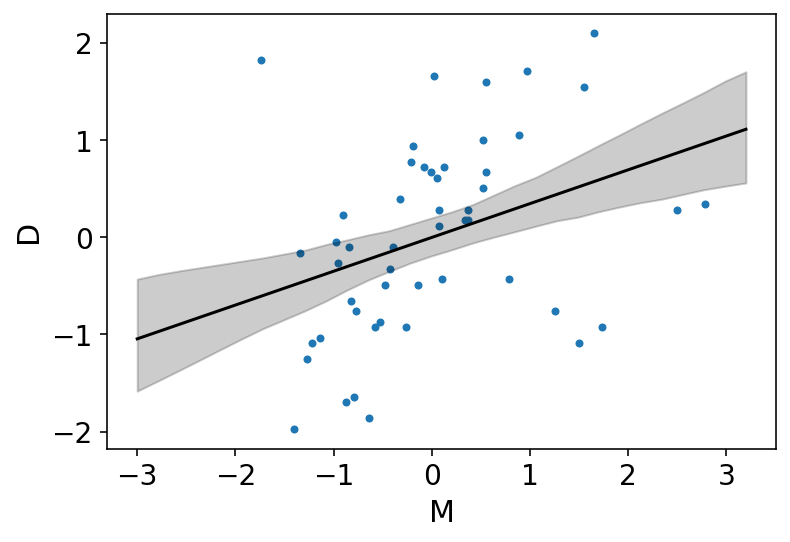

In [19]:
sample_alpha = posterior_5_2["alpha"][0]
sample_betaM = posterior_5_2["betaM"][0]
sample_sigma = posterior_5_2["sigma"][0]

M_seq = tf.linspace(start=-3., stop=3.2, num=30)
M_seq = tf.cast(M_seq, tf.float32)

# we are creating a new model for the test values
jdc_5_2_test = model_5_2(M_seq)

# we will sample it using the trace_5_1
ds, samples = jdc_5_2_test.sample_distributions(value=[
    sample_alpha, 
    sample_betaM, 
    sample_sigma, 
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

# plot it all
az.plot_pair(d[["M", "D"]].to_dict(orient="list"))
plt.fill_between(M_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);
plt.plot(M_seq, mu_mean, "k");

Above plot is showing that the influence of marriage rate is strongly positive with divorce rate

##### Code 5.7


Author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate other. 

How do we understand all this ?

He explains that here we may want to think **causally**. 

Few interesting assumptions (or rather deductions) -

a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D

M -> D

A -> M

and yet another way is to use **DAG** (Directed Acyclic Graphs)


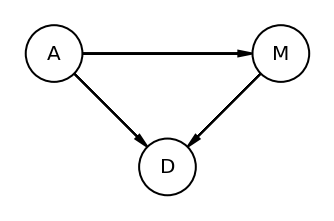

In [20]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**.

**MEDIATION** - Let's say that **A** did not directly influenced **D**; rather it did it via **M**. This type of relationship is called *Mediation*


Author raises many interesting questions here. He asks if there is indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a **spurious** coorelation between marriage rate and divorce rate





##### Code 5.8 

Checking conditional indpendencies

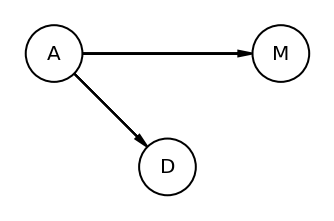

In [21]:
# Note - There is no explicity code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

In [22]:
DMA_dag2 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

('D', 'M', {'A'})


##### Code 5.9

Checking conditional indpenedencies in the DAG1

In [23]:
DMA_dag1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
           for t in all_independencies if t != s):
        print(s)

Executing above cell should not display anything as in the DAG1 (where all nodes are connected to each other) there are no conditional indpedencies.

##### Code 5.10

In [24]:
def model_5_3(median_age_data, marriage_rate_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))          
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data + betaM * marriage_rate_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_3 = model_5_3(tdf.A, tdf.M)

posterior_5_3, trace_5_3 = sample_posterior(
                                jdc_5_3, 
                                observed_data=(tdf.D,), 
                                params=['alpha', 'betaA', 'betaM', 'sigma'])

In [25]:
az.summary(trace_5_3, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],0.11,0.13,-0.04,0.24
betaA[0],-0.26,0.39,-0.68,0.14
betaM[0],0.10,0.12,-0.04,0.23
sigma[0],0.38,0.37,0.01,0.82


Let's try to understand the above table generated by arviz.

In the model above, we had include both the predictors i.e. M & A. The weights of M i.e. betaM is approaching zero where as betaA is more or less unchanged.


/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


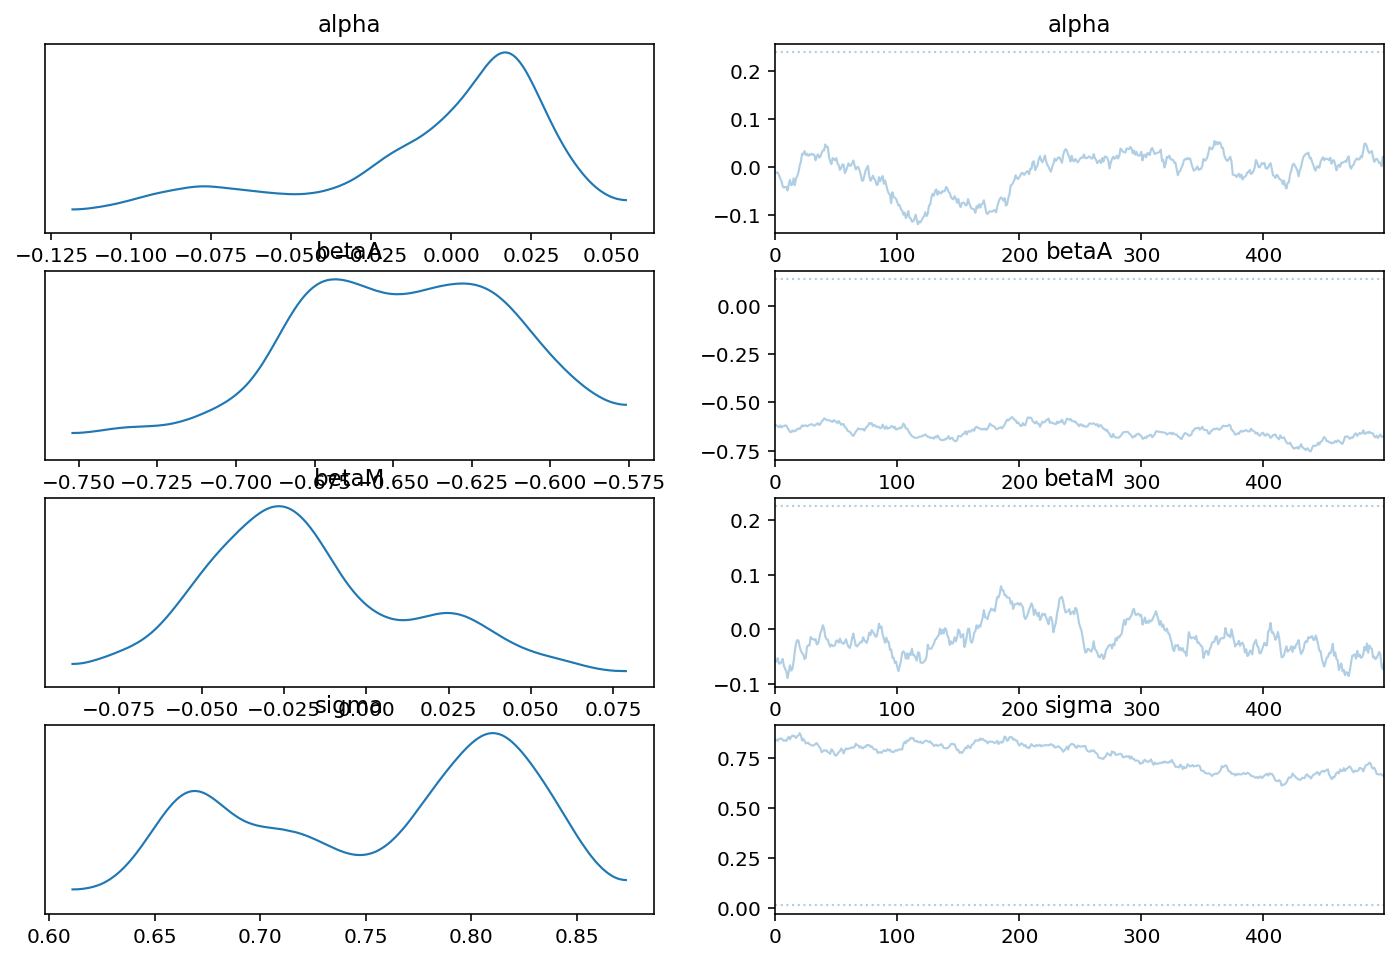

In [26]:
az.plot_trace(trace_5_3);

##### Code 5.11

Here we will take the help of forest plot to compare the posteriors of various models that we have built so far

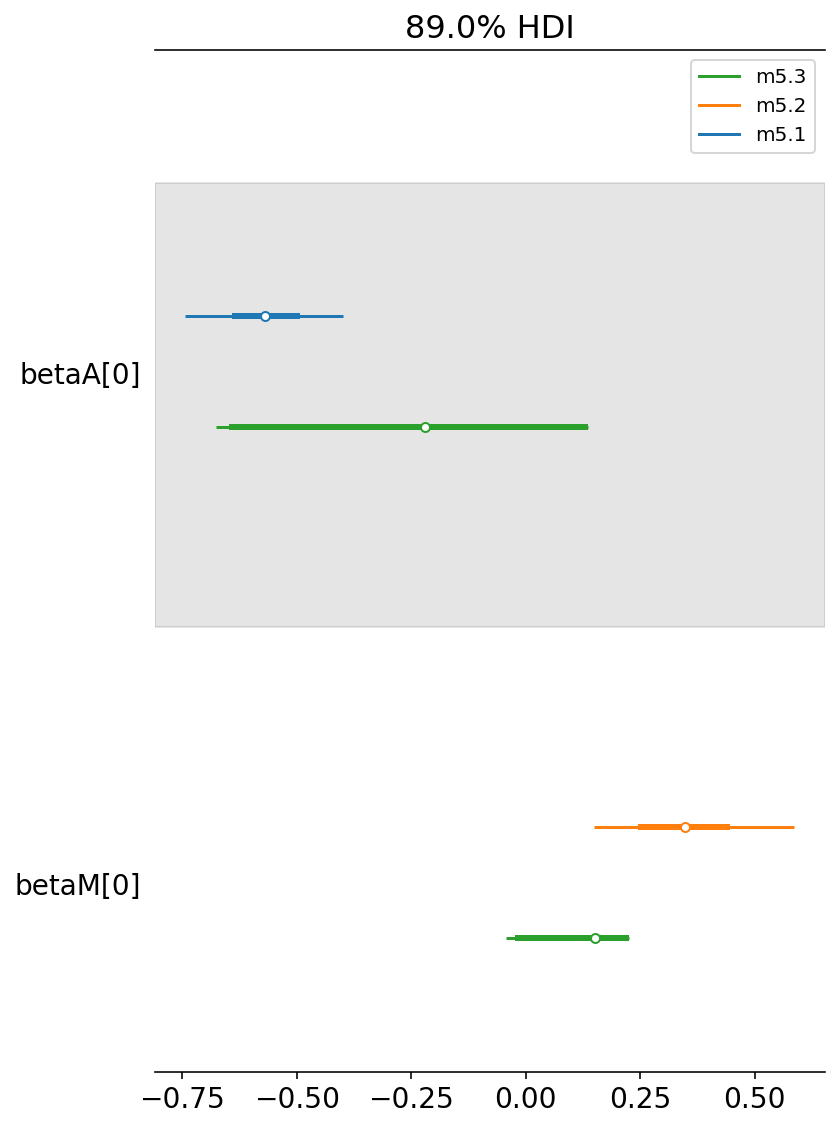

In [27]:
coeftab = {"m5.1": trace_5_1,
           "m5.2": trace_5_2,
           "m5.3": trace_5_3}

az.plot_forest(list(coeftab.values()), model_names=list(coeftab.keys()),combined=True,
               var_names=["betaA", "betaM"], hdi_prob=0.89);

Let's learn how to read above plot

m5.1 is our first model where we had used betaA. If we compare it to m5.3 it is more or less at the same place.

whereas,

m5.2 is our second model where we had used betaM. If we compare it to m5.3, it is now closer to zero. 

This is another way to read/plot what we saw in the arviz summary in Code 5.10


From all this, we can say that - once we know median age at marriage for a State, there is little or no additional predictive power in also knowing the rate of marriage in that state

##### Code 5.12 (TODO)

Possibly revisit this to do what professor has asked to do instead of just translating the code in the cell

In [28]:
N = 50  # number of simulated States
age = tfd.Normal(loc=0., scale=1.).sample((N,))  # sim A
mar = tfd.Normal(loc=age, scale=1.).sample()  # sim A -> M
div = tfd.Normal(loc=age, scale=1.).sample()  # sim A -> D

##### Code 5.13

Following few cells are all about how to plot multivariate posteriors. 

Previously we had only 1 predictor variable and hence a single scatterplot can convey a lot of information. Addition of regression lines and intervals also helped in estimating the size and uncertainity.

However, in the case multivariate regression we would have use other types of plots. 

Author mentions that we need to also know how to select the proper type of plot for a given problem.

He explains 3 types of plots -

* Predictor residual plots

* Posterior prediction plots

* Counterfactual plots



In [29]:
# we are first redefining our first model. It is exactly the same as m5_1

def model_5_4(median_age_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data
        
      M = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="M"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_4 = model_5_4(tdf.A)

posterior_5_4, trace_5_4 = sample_posterior(
                                jdc_5_4, 
                                observed_data=(tdf.D,), 
                                params=['alpha', 'betaA', 'sigma'])

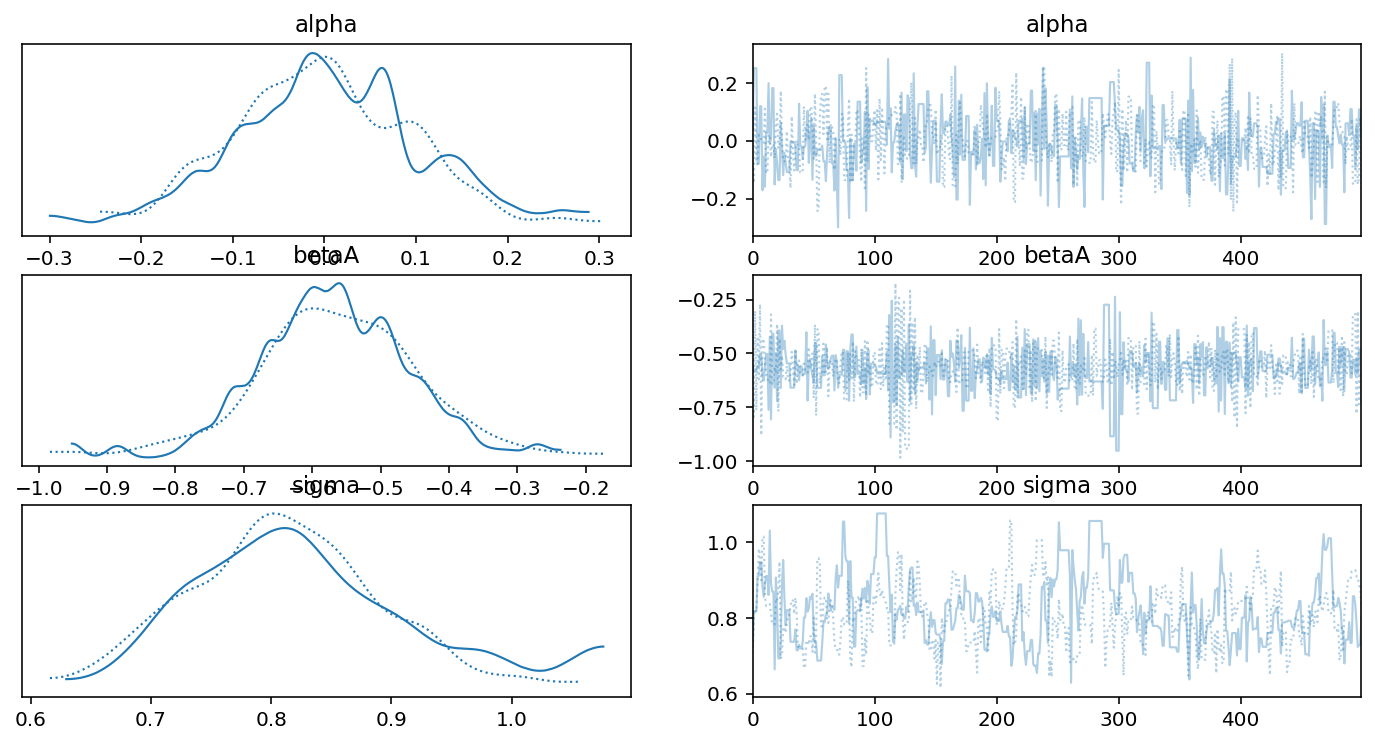

In [30]:
az.plot_trace(trace_5_4);

##### Code 5.14

First is **Predictor residual plot**

In [31]:
sample_alpha = posterior_5_4["alpha"][0]
sample_betaA = posterior_5_4["betaA"][0]
sample_sigma = posterior_5_4["sigma"][0]

ds, samples = jdc_5_4.sample_distributions(value=[
    sample_alpha,
    sample_betaA,
    sample_sigma,
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_resid = d.M.values - mu_mean

##### Code 5.15

Second is **Posterior prediction plots**

In [32]:
sample_alpha = posterior_5_3["alpha"][0]
sample_betaA = posterior_5_3["betaA"][0]
sample_betaM = posterior_5_3["betaM"][0]
sample_sigma = posterior_5_3["sigma"][0]

ds, samples = jdc_5_3.sample_distributions(value=[
    sample_alpha,
    sample_betaA,
    sample_betaM,
    sample_sigma, 
    None
])

mu_pred = ds[-1].distribution.loc

mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0).numpy()

# get the simulated D
D_sim = samples[-1]
D_PI = tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0)    

D_sim.shape

TensorShape([500, 50])

##### Code 5.16

Plot predictions against the observed

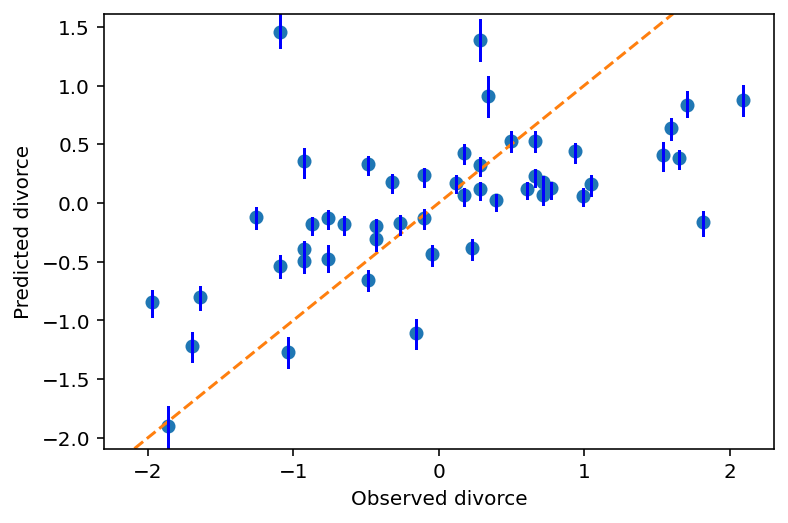

In [33]:
ax = plt.subplot(ylim=(float(mu_PI.min()), float(mu_PI.max())),
                 xlabel="Observed divorce", ylabel="Predicted divorce")
plt.plot(d.D, mu_mean, "o")
x = np.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

The diagonal line shows **perfect predictions**. 

##### Code 5.17

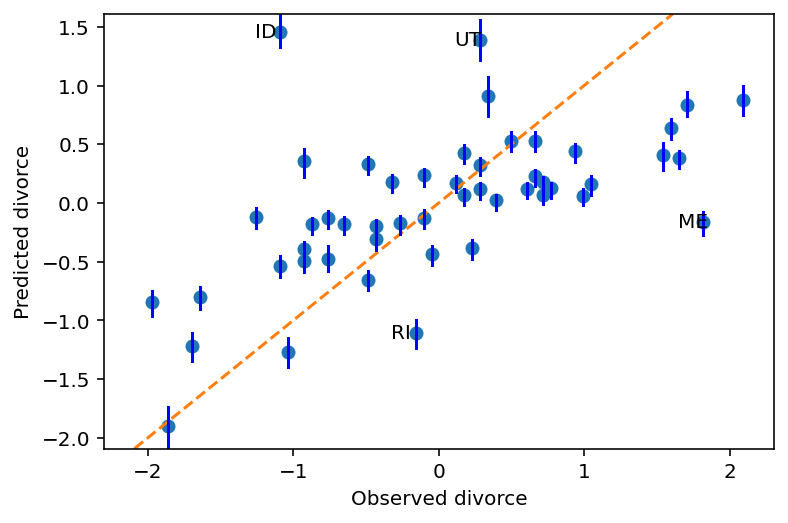

In [34]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5),
                    textcoords="offset pixels")
fig

Remember that the above graph is draw using m5_3 that had taken both predictor variables in account.

According to book, above figure shows -
"Model under-predicts for States with very high divorce rate while it over-predicts for states with very low divorce rates."

**I am not able to interpret that :(**


Some states, the ones which are labelled i.e. Idaho (ID), Utah (UT) have lower divorce rates because of religious regions. 


##### Code 5.18 

In [35]:
N = 100  # number of cases
# x_real as Gaussian with mean 0 and stddev 1
x_real = tfd.Normal(loc=0., scale=1.).sample((N,))
# x_spur as Gaussian with mean=x_real
x_spur = tfd.Normal(loc=x_real, scale=1.).sample()
# y as Gaussian with mean=x_real
y = tfd.Normal(loc=x_real, scale=1.).sample()
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

In [36]:
d

,y,x_real,x_spur
0,2.340000,0.430774,-0.529150
1,1.122599,-0.448829,-0.168145
2,0.285714,1.609063,1.522722
3,0.766254,1.530701,0.728517
4,0.478231,0.518983,0.522742
...,...,...,...
95,2.502886,-0.434121,-0.352779
96,0.161711,0.926871,3.106744
97,-0.367857,-0.352651,0.106548
98,2.087906,-0.472500,0.855710


##### Code 5.19

Third type of plot is called **Counterfactual Plots**

The simplest use of counterfactual plot is to see how the prediction changes as we change **only one** predictor at a time.

In [37]:
# Reloading the dataset

d = pd.read_csv(WAFFLE_DIVORCE_DATASET_PATH, sep=";")

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('WaffleDivorce', d, ['A', 'D', 'M'])

In [38]:
def model_5_3_A(median_age_data, marriage_rate_data):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaA = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaA"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))          
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaA * median_age_data + betaM * marriage_rate_data
        
      divorce = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="divorce"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    

def model_5_X_M(median_age_data):
    def _generator():
      alphaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alphaM"), sample_shape=1))
      betaAM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaAM"), sample_shape=1))      
      sigmaM = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigmaM"), sample_shape=1))
    
      mu_M =  alphaM + betaAM * median_age_data 
        
      M = yield tfd.Independent(tfd.Normal(loc=mu_M, scale=sigmaM, name="M"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    

## First model
jdc_5_3_A = model_5_3_A(tdf.A, tdf.M)
posterior_5_3_A, trace_5_3_A = sample_posterior(
                        jdc_5_3_A, 
                        observed_data=(tdf.D,), 
                        params=['alpha', 'betaA', 'betaM', 'sigma'])

## Second model
jdc_5_X_M = model_5_X_M(tdf.A)
posterior_5_X_M, trace_5_X_M = sample_posterior(
                        jdc_5_X_M, 
                        observed_data=(tdf.M,), 
                        params=['alpha', 'betaA', 'sigma'])


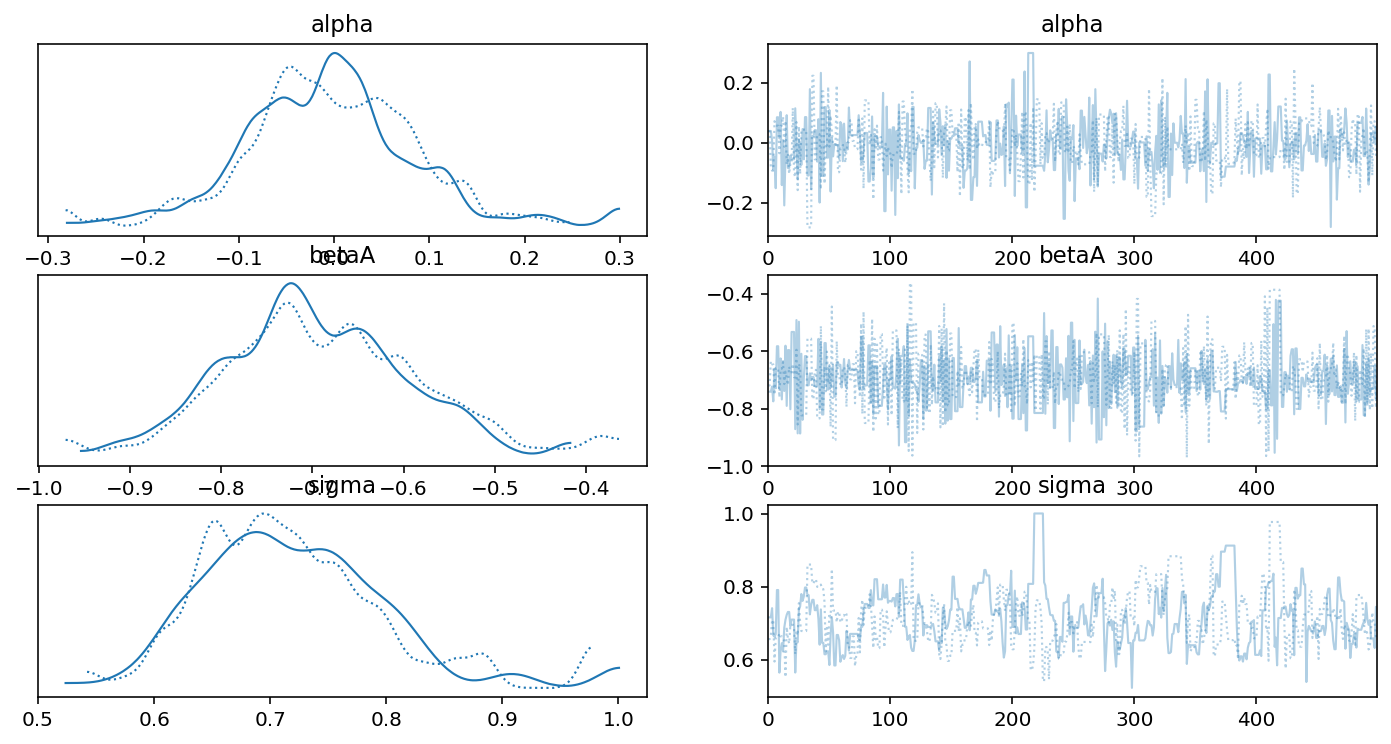

In [39]:
az.plot_trace(trace_5_X_M);

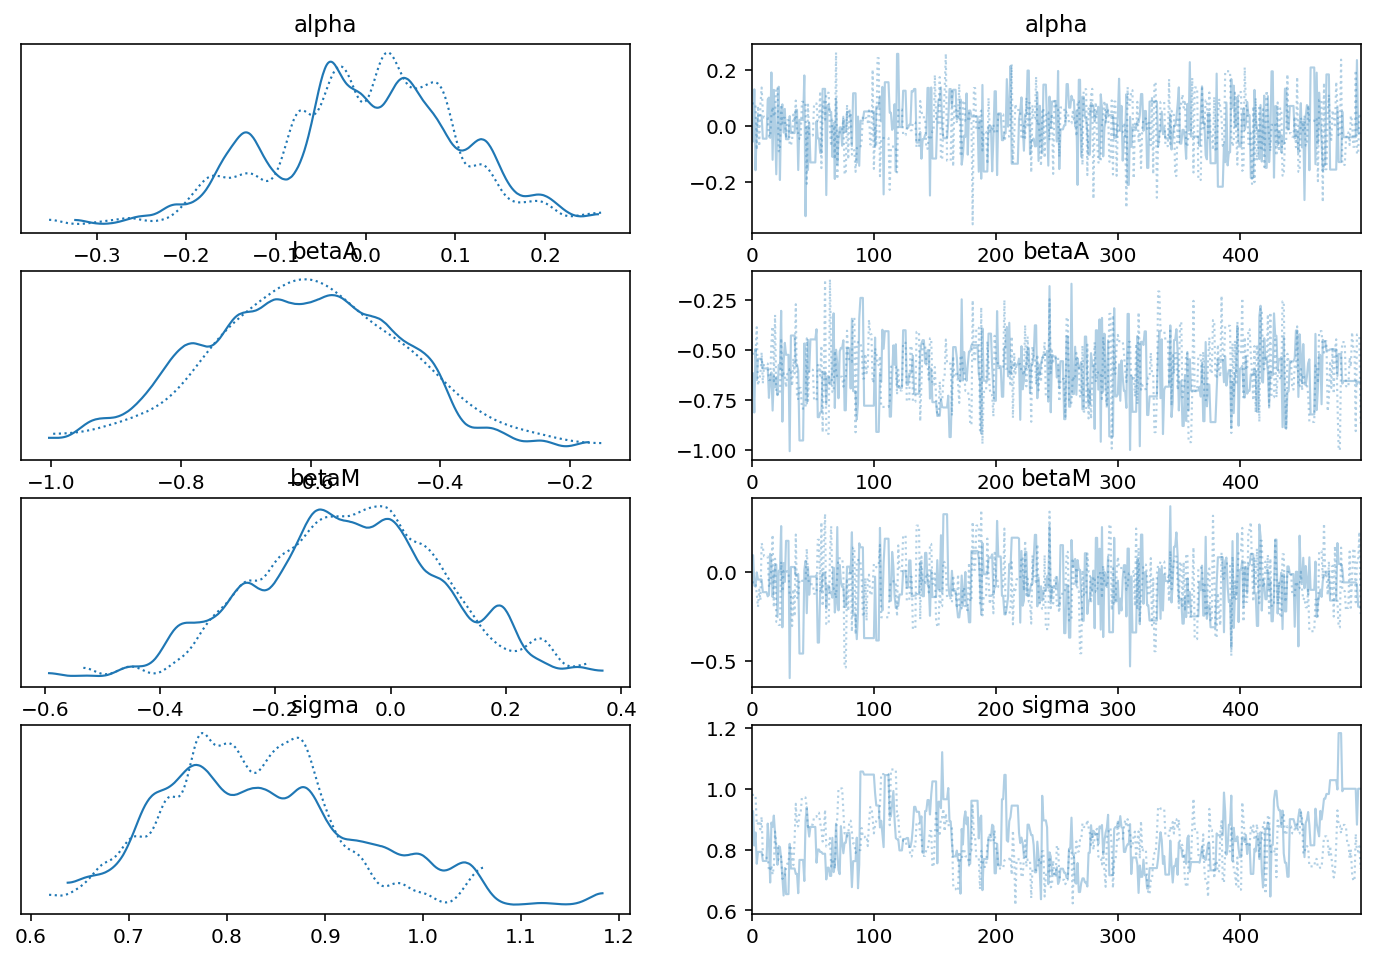

In [40]:
az.plot_trace(trace_5_3_A);

##### Code 5.20

In [41]:
A_seq = tf.linspace(-2.0, 2.0, num=30)
A_seq = tf.cast(A_seq, dtype=tf.float32)

##### Code 5.21

In [42]:
sample5X_alpha = posterior_5_X_M["alpha"][0]
sample5X_betaA = posterior_5_X_M["betaA"][0]
sample5X_sigma = posterior_5_X_M["sigma"][0]

# simulate M using A_seq
jdc_5_X_M_test = model_5_X_M(A_seq)

samples = jdc_5_X_M_test.sample(value=[
    sample5X_alpha, 
    sample5X_betaA, 
    sample5X_sigma, 
    None
])

M_sim = samples[-1]

M_sim.shape

TensorShape([500, 30])

In [43]:
# time to simulate D using M
sample53A_alpha  = posterior_5_3_A["alpha"][0]
sample53A_betaA  = posterior_5_3_A["betaA"][0]
sample53A_betaM  = posterior_5_3_A["betaM"][0]
sample53A_sigma  = posterior_5_3_A["sigma"][0]

jdc_5_3_A_test = model_5_3_A(A_seq, M_sim)

_, _, _, _, D_sim = jdc_5_3_A_test.sample(value=[
    sample53A_alpha,
    sample53A_betaA,
    sample53A_betaM,
    sample53A_sigma,
    None
])

D_sim.shape

TensorShape([500, 30])

##### Code 5.22

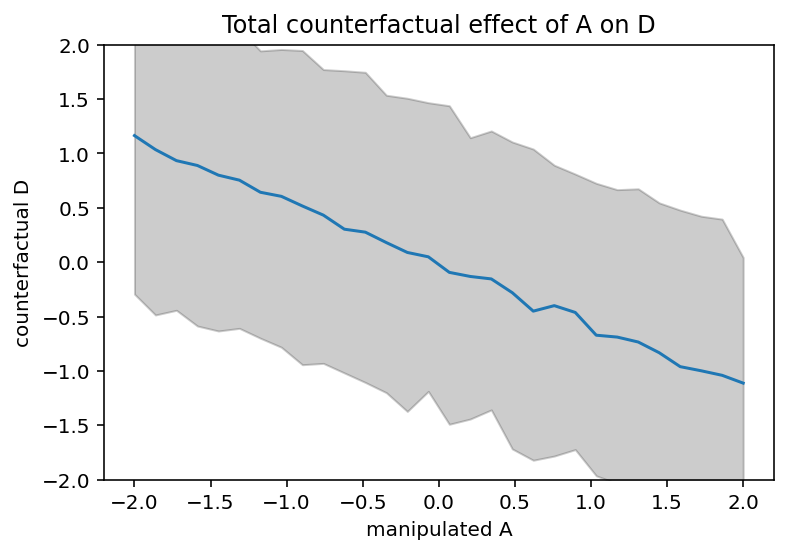

In [44]:
# display counterfactual predictions
plt.plot(A_seq, tf.reduce_mean(D_sim, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated A", ylabel="counterfactual D")
plt.fill_between(A_seq, *tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of A on D");

##### Code 5.23  

In [45]:
M_seq = tf.linspace(-2.0, 2.0, num=30)
M_seq = tf.cast(M_seq, dtype=tf.float32)

def compute_D_from_posterior_using_M(m):
    mu = sample53A_alpha + sample53A_betaM * m
    return tfd.Normal(loc=mu, scale=sample53A_sigma).sample()        

D_sim = tf.transpose(tf.squeeze(tf.vectorized_map(compute_D_from_posterior_using_M, M_seq)))
D_sim.shape

TensorShape([500, 30])

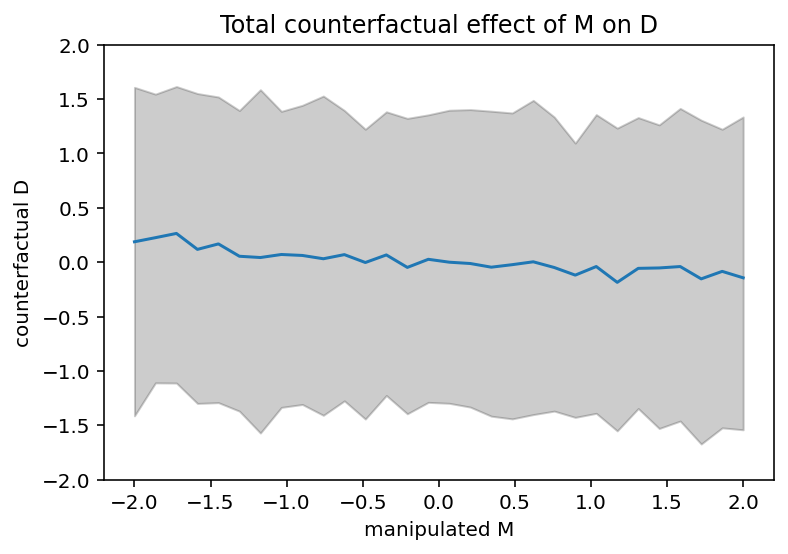

In [46]:
# display counterfactual predictions
plt.plot(M_seq, tf.reduce_mean(D_sim, 0))
plt.gca().set(ylim=(-2, 2), xlabel="manipulated M", ylabel="counterfactual D")
plt.fill_between(M_seq, *tfp.stats.percentile(D_sim, q=(5.5, 94.5), axis=0),
                 color="k", alpha=0.2)
plt.title("Total counterfactual effect of M on D");

##### Code 5.24, 5.25 and 5.26

Here the author explains how to do above manually in the overthinking box.

Due to the lack of Predictive support in tensorflow prob I had to do it anyways. So refer to above cells.

##### Code 5.27

Previous example used multiple predictors to show case spurious association but sometimes you do need multiple predictor variables as they do have influence on the outcome.

It is possible that one predictor variable is +ively related to outcome whereas the other one is -ively correlated.

We are going to use a new dataset called Milk.

Question that we want to answer is - **To what extent energy content of milk, measured in KCal, is related to the percent of the brain mass that is neocortex**.



In [47]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   clade           29 non-null     object 
 1   species         29 non-null     object 
 2   kcal.per.g      29 non-null     float64
 3   perc.fat        29 non-null     float64
 4   perc.protein    29 non-null     float64
 5   perc.lactose    29 non-null     float64
 6   mass            29 non-null     float64
 7   neocortex.perc  17 non-null     float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


* kcal.per.g - Kilocalories of energy per gram of milk
* mass - Average female body mass, in KG
* neocortex.perc - Percent of total brain mass that is neocortex mass

Although not mentioned in the question that was asked above, we are considering the female body mass as well. This is to see the masking that hides the relationships among the variables.


## 5.2 Masked relationship

##### Code 5.28

In [48]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('Milk', d, ['K', 'N', 'M'])

##### Code 5.29

A Simple Bivariate model between KCal and NeoCortex percent

In [49]:
# N => Standardized Neocortex percent

def model_5_5(neocortex_percent_std):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="alpha"), sample_shape=1))
      betaN = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1., name="betaN"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaN * neocortex_percent_std
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_5 = model_5_5(tdf.N)

samples = jdc_5_5.sample()

samples

StructTuple(
  var0=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.088368], dtype=float32)>,
  var1=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.21535683], dtype=float32)>,
  var2=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.02216171], dtype=float32)>,
  var3=<tf.Tensor: shape=(29,), dtype=float32, numpy=
    array([-0.36683145,         nan,         nan,         nan,         nan,
           -0.00878006, -0.01931753,  0.10746448,         nan,  0.11983375,
           -0.23149405, -0.12633419, -0.1605766 ,         nan,         nan,
            0.1735494 ,         nan,  0.21492481,         nan,  0.2736908 ,
                   nan,  0.08445799,         nan,  0.18661983,  0.25879326,
                   nan,  0.11545581,  0.40304822,  0.39278224], dtype=float32)>
)

If you see above displayed samples, you would see lot of NaN. Now tensorflow prob does not complain and/or throw
an exception here but it is going to cause lot of pain.

In other words, we must not have this situation i.e. presence of NaN

##### Code 5.30

In [50]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

We have lot of data missing in the neorcortex.perc colums

##### Code 5.31

Drop all the cases with missing values. This is known as **COMPLETE CASE ANANLYSIS**

In [51]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

# we now have only 17 rows
dcc.describe()

,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,1.700000e+01,17.000000
mean,0.657647,36.063529,16.255294,47.681176,16.637647,67.575882,0.098654,-2.821273e-15,0.033852
std,0.172899,14.705419,5.598480,13.585261,23.582322,5.968612,1.071235,1.000000e+00,1.138400
min,0.460000,3.930000,7.370000,27.090000,0.120000,55.160000,-1.125913,-2.080196e+00,-2.097830
25%,0.490000,27.180000,11.680000,37.800000,1.550000,64.540000,-0.940041,-5.086413e-01,-0.591039
50%,0.620000,37.780000,15.800000,46.880000,5.250000,68.850000,-0.134597,2.134697e-01,0.127441
75%,0.800000,50.490000,20.850000,55.200000,33.110000,71.260000,0.980633,6.172487e-01,1.212020
max,0.970000,55.510000,25.300000,70.770000,79.430000,76.300000,2.033906,1.461666e+00,1.727359


In [52]:
tdcc = df_to_tensors('Milk', dcc, ['K', 'N', 'M'])

##### Code 5.32

In [53]:
jdc_5_5_draft = model_5_5(tdcc.N)

samples = jdc_5_5_draft.sample()

samples

StructTuple(
  var0=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8958276], dtype=float32)>,
  var1=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.19303893], dtype=float32)>,
  var2=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.8995368], dtype=float32)>,
  var3=<tf.Tensor: shape=(17,), dtype=float32, numpy=
    array([ 0.03421152,  5.9697385 ,  1.153639  , -5.603297  ,  3.0911639 ,
           -4.7067747 , -0.64546466, -2.4437246 ,  5.3220267 ,  1.3863896 ,
           -0.4521532 ,  1.7282491 ,  1.975863  ,  0.787782  ,  3.0646334 ,
           -2.6402874 ,  4.7237225 ], dtype=float32)>
)

You should not see an NaN in the samples

##### Code 5.33

Investigate if we have proper priors by plotting 50 prior regression lines

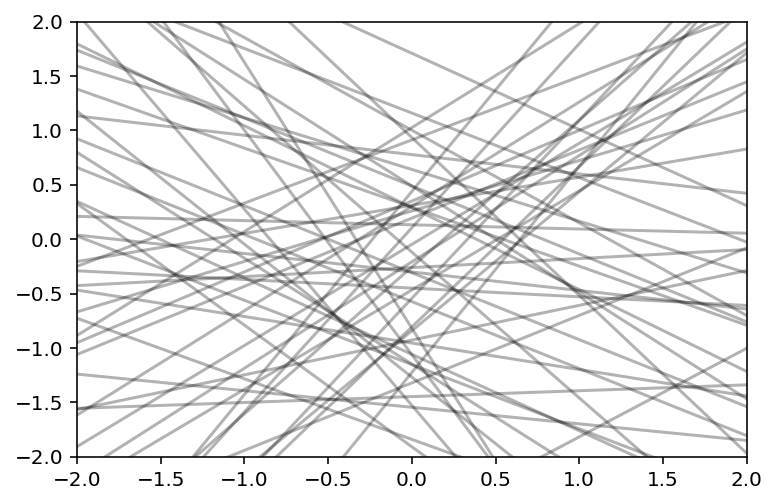

In [54]:
xseq = tf.constant([-2.0,2.0], dtype=tf.float32)

sample_alpha, sample_betaN, sample_sigma, _ = model_5_5(xseq).sample(1000)

# we simply compute for the two possible values
mu_pred_0 = sample_alpha + sample_betaN * -2.0
mu_pred_1 = sample_alpha + sample_betaN * 2.0

mu_pred = tf.concat([mu_pred_0, mu_pred_1], axis=1)
    
plt.subplot(xlim=xseq.numpy(), ylim=xseq.numpy())
for i in range(50):
    plt.plot(xseq, mu_pred[i], "k", alpha=0.3)

Above does not look good. We should have better priors for $\alpha$ so that it sticks closer to zero

##### Code 5.34

In [55]:
def model_5_5(neocortex_percent_std):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaN = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaN"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaN * neocortex_percent_std
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_5 = model_5_5(tdcc.N)

posterior_5_5, trace_5_5 = sample_posterior(
                                jdc_5_5, 
                                observed_data=(tdcc.K,),
                                params=['alpha', 'betaN', 'sigma'])

##### Code 5.35

In [56]:
az.summary(trace_5_5, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],0.06,0.16,-0.15,0.35
betaN[0],0.12,0.29,-0.36,0.56
sigma[0],1.12,0.20,0.80,1.39


##### Code 5.36

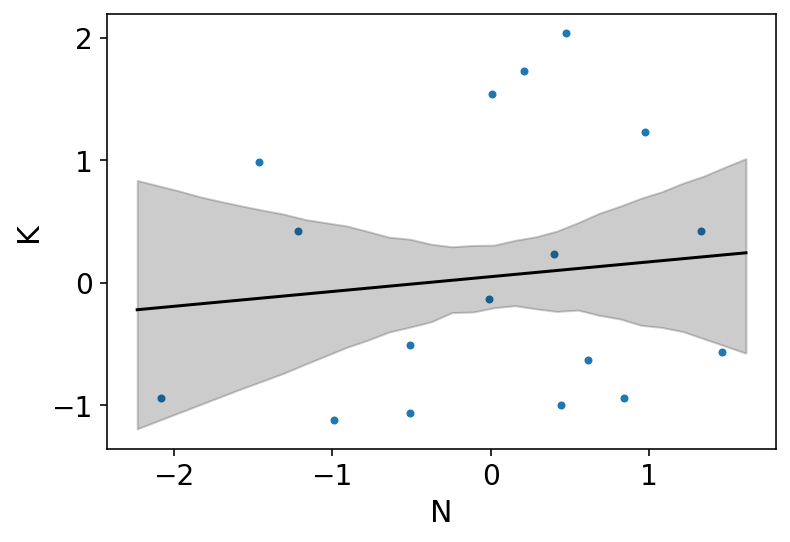

In [57]:
xseq = tf.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha =  posterior_5_5["alpha"][0]
sample_betaN =  posterior_5_5["betaN"][0]
sample_sigma =  posterior_5_5["sigma"][0] 

jdc_5_5_test = model_5_5(xseq)

ds, samples = jdc_5_5_test.sample_distributions(value=[
    sample_alpha, 
    sample_betaN, 
    sample_sigma, 
    None
])

mu_pred = ds[-1].distribution.loc

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);


Above plot displays weak association when using simple bivariate regression

##### Code 5.37

We now consider another predictor variable; the adult female body mass

In [58]:
def model_5_6(female_body_mass):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaM * female_body_mass
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_6 = model_5_6(tdcc.M)

posterior_5_6, trace_5_6 = sample_posterior(
                            jdc_5_6, 
                            observed_data=(tdcc.K,),
                            params=['alpha', 'betaM', 'sigma'])

az.summary(trace_5_6, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],0.05,0.16,-0.20,0.29
betaM[0],-0.27,0.20,-0.55,0.06
sigma[0],1.06,0.20,0.74,1.32


Log-mass is negatively correlated with KCal. The influence is stronger than that of neocortex percent but it is in the opposite direction.

##### Code 5.38

Now let's see what happens when we add both the predictor variables to the model

In [59]:
def model_5_7(neocortex_percent_std, female_body_mass):
    def _generator():
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.2, name="alpha"), sample_shape=1))
      betaN = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaN"), sample_shape=1))      
      betaM = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=0.5, name="betaM"), sample_shape=1))      
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))
    
      mu =  alpha + betaN * neocortex_percent_std + betaM * female_body_mass
        
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_7 = model_5_7(tdcc.N, tdcc.M)

posterior_5_7, trace_5_7 = sample_posterior(jdc_5_7, 
                              observed_data=(tdcc.K,), 
                              params=['alpha', 'betaN', 'betaM', 'sigma'])

az.summary(trace_5_7, round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0],0.06,0.14,-0.16,0.30
betaN[0],0.62,0.28,0.20,1.07
betaM[0],-0.64,0.24,-1.02,-0.27
sigma[0],0.85,0.16,0.62,1.09


By including both predictor variables in the regression, the posterior assocition of both with the outcome has increased.

##### Code 5.39

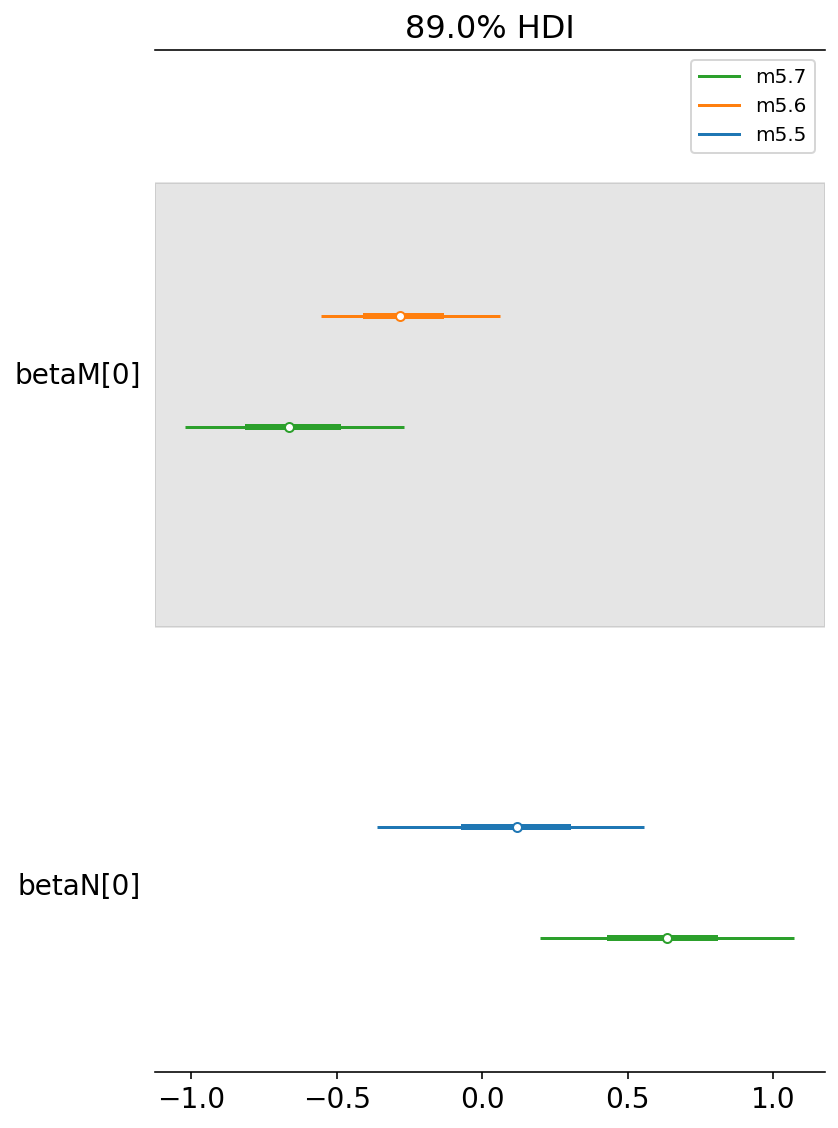

In [60]:
coeftab = {"m5.5": trace_5_5,
           "m5.6": trace_5_6,
           "m5.7": trace_5_7}

az.plot_forest(list(coeftab.values()), model_names=list(coeftab.keys()),combined=True,
               var_names=["betaM", "betaN"], hdi_prob=0.89);

##### Code 5.40

Counterfactual plot when setting N to zero and using M as the predictor variable 

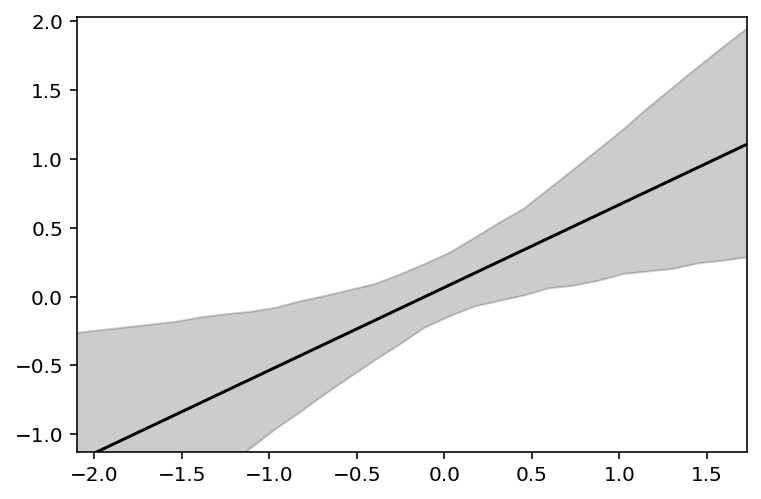

In [61]:
xseq = tf.linspace(start=dcc.M.min() - 0.15, stop=dcc.M.max() + 0.15, num=30)
xseq = tf.cast(xseq, dtype=tf.float32)

sample_alpha =  posterior_5_7["alpha"][0]
sample_betaN =  posterior_5_7["betaN"][0]
sample_betaM =  posterior_5_7["betaN"][0]
sample_sigma =  posterior_5_7["sigma"][0] 

mu_pred = tf.transpose(tf.squeeze(tf.vectorized_map(lambda x : sample_alpha + sample_betaN * x, xseq)))

# summarize samples across cases
mu_mean = tf.reduce_mean(mu_pred, 0)
mu_PI = tfp.stats.percentile(mu_pred, q=(5.5, 94.5), axis=0)

plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

##### Code 5.41

In [62]:
# M -> K <- N
# M -> N
n = 100
M = tfd.Normal(loc=0., scale=1.).sample((n,))
N = tfd.Normal(loc=M, scale=1.).sample()
K = tfd.Normal(loc=N - M, scale=1.).sample()

d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

d_sim

,K,N,M
0,-1.552208,-0.578348,0.649012
1,0.880341,-0.239790,0.240380
2,0.019080,1.747340,1.438984
3,-0.013291,-1.091810,-0.688836
4,-0.551834,-0.084260,-0.261867
...,...,...,...
95,0.914302,-0.398174,0.249125
96,0.826084,-2.787896,-2.478876
97,1.209143,-1.575581,-0.556915
98,-0.127283,0.705521,-0.221180


##### Code 5.42

In [63]:
# M -> K <- N
# N -> M
n = 100
N = tfd.Normal(loc=0., scale=1.).sample((n,))
M = tfd.Normal(loc=N, scale=1.).sample()
K = tfd.Normal(loc=N - M, scale=1.).sample()

d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = tfd.Normal(loc=0., scale=1.).sample((n,))
M = tfd.Normal(loc=M, scale=1.).sample()
K = tfd.Normal(loc=N - M, scale=1.).sample()

d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

##### Code 5.43 

The book uses `dagitty` an R package that can draw the DAG as well generate the equivalentDAGs given a DAG as input

At this point I do not have the corresponding function in python so I am manually specifying the equivalent DAGs (after seeing the result in RStudio as the book does not display the equivalentDAGs either)

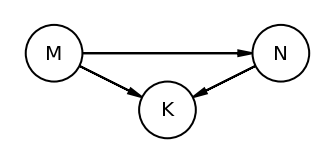

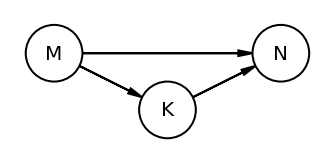

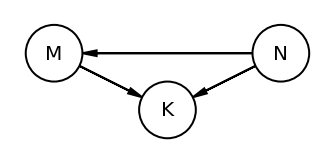

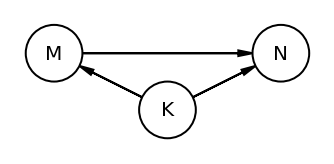

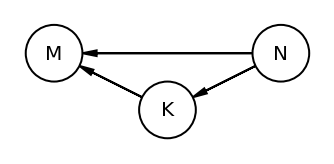

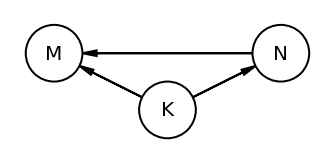

In [64]:
coordinates = {"M": (0, 0.5), "K": (1, 1), "N": (2, 0.5)}
node_names = ["M", "K", "N"]

equivalent_dags = [
    [("M", "K"), ("N", "K"), ("M", "N")],
    [("M", "K"), ("K", "N"), ("M", "N")],
    [("M", "K"), ("N", "K"), ("N", "M")],
    [("K", "M"), ("K", "N"), ("M", "N")],
    [("K", "M"), ("N", "K"), ("N", "M")],
    [("K", "M"), ("K", "N"), ("N", "M")]
]

for e in equivalent_dags:
    dag = CausalGraphicalModel(nodes=node_names, edges=e)    
    pgm = daft.PGM()
    for node in dag.dag.nodes:
        pgm.add_node(node, node, *coordinates[node])
    for edge in dag.dag.edges:
        pgm.add_edge(*edge)
        
    pgm.render()
    plt.gca().invert_yaxis()

##### Code 5.44

This section discusses Categorical Variables i.e. Discrete & Unordered variables.

We will again use HOWELL dataset here. In previous chapter, we had taken into consider *sex* variable and here we will model it as a categorical variable.

To start with let's load the dataset

In [65]:
d = pd.read_csv(HOWELL_DATASET_PATH, sep=";")
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


## 5.3 Categorical variables

##### Code 5.45


Here we are considering following model

$h_i \sim Normal(\mu_i,\sigma)$    

$\mu_i = \alpha + \beta_mm_i$   

$\alpha \sim Normal(178,20)$       

$\beta_m \sim Normal(0,10)$          

$\sigma \sim Exponential(1)$ 


*m* here is a categorical value and is 1 when we are dealing with males. This means that $\alpha$ is used
to predict both female and male heights.

But if we have a male then the height gets an extra $\beta_m$. This also means that $\alpha$ does not represent the average of all samples but rather the average of female height.


In [66]:
mu_female = tfd.Normal(loc=178., scale=20.).sample((int(1e4),))

diff = tfd.Normal(loc=0., scale=10.).sample((int(1e4),))

mu_male = tfd.Normal(loc=178.0, scale=20.).sample((int(1e4),)) + diff

sample_dict = {
    'mu_female' : mu_female.numpy(),
    'mu_male' : mu_male.numpy()
}

az.summary(az.from_dict(sample_dict), round_to=2, kind='stats', hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
mu_female,178.03,20.05,146.70,210.54
mu_male,178.38,22.32,144.01,214.91


The prior for male is wider (see std column). This is because it uses both the parameters.

Author explains that this makes assigning sensible priors harder. As show above, one of the category would have more uncertainity in the prediction as two priors are involved.



##### Code 5.46

Another approach is to use **INDEX VARIABLE**

In [67]:
d["sex"] = np.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int64

##### Code 5.47

In [68]:
tdf = df_to_tensors('Howell1', d, {
    'height' : tf.float32,     
    'sex'    : tf.int32
})


def model_5_8(sex):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=178., scale=20., name="alpha"), sample_shape=(2,)))                
      sigma = yield Root(tfd.Sample(tfd.Uniform(low=0., high=50., name="sigma"), sample_shape=1))

      # took long time to figure this out
      mu = tf.transpose(tf.gather(tf.transpose(alpha), sex))      
    
      height = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="height"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_8 = model_5_8(tdf.sex)

posterior_5_8, trace_5_8 = sample_posterior(
                                jdc_5_8,
                                observed_data=(tdf.height,),
                                params=['alpha', 'sigma'])

# now here is the special thing we have to do here
# alpha is actually a vector so for az_trace to display
# it properly I would have to extract it properly
female_alpha, male_alpha = tf.split(posterior_5_8["alpha"][0], 2, axis=1)

# reformatted 
posterior_5_8_new = {
    "female_alpha" : female_alpha.numpy(),
    "male_alpha" : male_alpha.numpy(),
    "sigma" : posterior_5_8["sigma"][0]
}

az.summary(az.from_dict(posterior_5_8_new), round_to=2, kind='stats', hdi_prob=0.89)

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
female_alpha,134.95,1.45,132.63,137.24
male_alpha,142.62,2.16,139.47,146.35
sigma,27.45,0.89,26.36,29.19


##### Code 5.48

What is the expected difference between females and males ?

We can use the samples from the posterior to compute this.

In [69]:
posterior_5_8_new.update({    
    "diff_fm" : female_alpha.numpy() - male_alpha.numpy()
})

az.summary(az.from_dict(posterior_5_8_new), round_to=2, kind='stats', hdi_prob=0.89)

/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
female_alpha,134.95,1.45,132.63,137.24
male_alpha,142.62,2.16,139.47,146.35
sigma,27.45,0.89,26.36,29.19
diff_fm,-7.67,2.87,-12.50,-3.90


Note that the above computation (i.e. diff) appeared in the arviz summary. This kind of calculation is called a **CONTRAST**. 

##### Code 5.49


We explore the mile dataset again. We are now interested in `clade` variable which encodes the broad taxonomic membership of each species


In [70]:
d = pd.read_csv(MILK_DATASET_PATH, sep=";")
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

##### Code 5.50

In [71]:
d["clade_id"] = d.clade.astype("category").cat.codes

d["clade_id"]

0     3
1     3
2     3
3     3
4     3
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    2
15    2
16    2
17    2
18    2
19    2
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
Name: clade_id, dtype: int8

In [72]:
d.clade

0        Strepsirrhine
1        Strepsirrhine
2        Strepsirrhine
3        Strepsirrhine
4        Strepsirrhine
5     New World Monkey
6     New World Monkey
7     New World Monkey
8     New World Monkey
9     New World Monkey
10    New World Monkey
11    New World Monkey
12    New World Monkey
13    New World Monkey
14    Old World Monkey
15    Old World Monkey
16    Old World Monkey
17    Old World Monkey
18    Old World Monkey
19    Old World Monkey
20                 Ape
21                 Ape
22                 Ape
23                 Ape
24                 Ape
25                 Ape
26                 Ape
27                 Ape
28                 Ape
Name: clade, dtype: object

Based on above it seems that pandas is first sorting the categories by name and then assigning the number. So,

* Ape = 0
* New World Monkey = 1
* Old World Monkey = 2
* Strepsirrhine    = 3


##### Code 5.51

We will now model again using the index variables

In [73]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())

tdf = df_to_tensors('Milk', d, {
    'K' : tf.float32,     
    'clade_id' : tf.int64
})

CLADE_ID_LEN = len(set(d.clade_id.values))

def model_5_9(clade_id):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=.5, name="alpha"), sample_shape=(CLADE_ID_LEN,)))                
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))        

      mu = tf.transpose(tf.gather(tf.transpose(alpha), tf.cast(clade_id, dtype=tf.int64)))      
    
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_9 = model_5_9(tdf.clade_id)

posterior_5_9, trace_5_9 = sample_posterior(
                                jdc_5_9,
                                observed_data=(tdf.K,),
                                params=['alpha', 'sigma'])

# now here is the special thing we have to do here
# alpha is actually a vector so for az_trace to display
# it properly I would have to extract it properly
ape_alpha, nwm_alpha, owm_alpha, strep_alpha = tf.split(posterior_5_9["alpha"][0], 4, axis=1)

# reformatted 
updated_posterior_5_9 = {
    "ape_alpha" : ape_alpha.numpy(),
    "nwm_alpha" : nwm_alpha.numpy(),
    "owm_alpha" : owm_alpha.numpy(),
    "strep_alpha" : strep_alpha.numpy(),
    "sigma" : posterior_5_9["sigma"][0]
}

az.summary(az.from_dict(updated_posterior_5_9), round_to=2, kind='stats', hdi_prob=0.89)


/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
ape_alpha,-0.50,0.22,-0.89,-0.18
nwm_alpha,0.39,0.30,-0.01,0.88
owm_alpha,0.60,0.23,0.24,0.93
strep_alpha,-0.30,0.36,-0.83,0.40
sigma,0.85,0.14,0.62,1.05


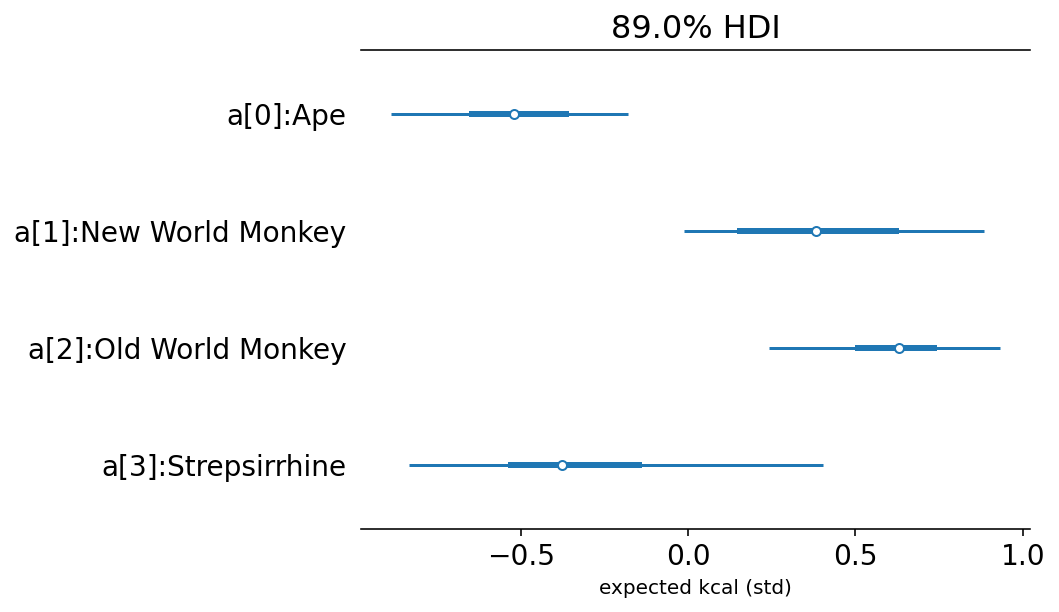

In [74]:
labels = ["a[" + str(i) + "]:" + s
          for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest({"a" : trace_5_9.posterior["alpha"].values[0][None, ...]}, hdi_prob=0.89)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)");

##### Code 5.52

In [75]:
np.random.seed(63)
d["house"] = np.random.choice(np.repeat(np.arange(4), 8), d.shape[0], False)

In [76]:
d.house

0     2
1     3
2     1
3     3
4     0
5     0
6     0
7     2
8     0
9     0
10    1
11    3
12    1
13    1
14    3
15    1
16    2
17    0
18    3
19    2
20    3
21    0
22    3
23    1
24    3
25    2
26    0
27    2
28    2
Name: house, dtype: int64

##### Code 5.53

In [77]:
tdf = df_to_tensors('Milk', d, {
    'K' : tf.float32,     
    'clade_id' : tf.int32,
    'house' : tf.int32
})

CLADE_ID_LEN = len(set(d.clade_id.values))
HOUSE_ID_LEN = len(set(d.house.values))

def model_5_10(clade_id, house_id):    
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=.5, name="alpha"), sample_shape=(CLADE_ID_LEN,)))                
      house = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=.5, name="house"), sample_shape=(HOUSE_ID_LEN,)))                
      sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1., name="sigma"), sample_shape=1))        

      mu = tf.transpose(tf.gather(tf.transpose(alpha), tf.cast(clade_id, dtype=tf.int64))) + tf.transpose(tf.gather(tf.transpose(house), house_id))
    
      K = yield tfd.Independent(tfd.Normal(loc=mu, scale=sigma, name="K"), reinterpreted_batch_ndims=1)

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_5_10 = model_5_10(tdf.clade_id, tdf.house)

posterior_5_10, trace_5_10 = sample_posterior(
                                jdc_5_10,
                                observed_data=(tdf.K,),
                                params=['alpha', 'house', 'sigma'])

# now here is the special thing we have to do here
# alpha is actually a vector so for az_trace to display
# it properly I would have to extract it properly
ape_alpha, nwm_alpha, owm_alpha, strep_alpha = tf.split(posterior_5_10["alpha"][0], 4, axis=1)
house_0, house_1, house_2, house_3 = tf.split(posterior_5_10["house"][0], 4, axis=1)

# reformatted 
updated_posterior_5_10 = {
    "ape_alpha" : ape_alpha.numpy(),
    "nwm_alpha" : nwm_alpha.numpy(),
    "owm_alpha" : owm_alpha.numpy(),
    "strep_alpha" : strep_alpha.numpy(),
    "house_0" : house_0.numpy(),
    "house_1" : house_1.numpy(),
    "house_2" : house_2.numpy(),
    "house_3" : house_3.numpy(),    
    "sigma" : posterior_5_10["sigma"][0]
}

az.summary(az.from_dict(updated_posterior_5_10), round_to=2, kind='stats', hdi_prob=0.89)


/Users/ksachdeva/rethinkingtfp/lib/python3.7/site-packages/arviz/data/base.py:221: UserWarning: More chains (500) than draws (1). Passed array should have shape (chains, draws, *shape)
  UserWarning,


,mean,sd,hdi_5.5%,hdi_94.5%
ape_alpha,-0.48,0.28,-0.92,-0.06
nwm_alpha,0.30,0.28,-0.10,0.80
owm_alpha,0.64,0.29,0.21,1.12
strep_alpha,-0.53,0.30,-1.03,-0.12
house_0,0.22,0.30,-0.24,0.69
house_1,-0.02,0.31,-0.47,0.45
house_2,0.19,0.30,-0.22,0.71
house_3,-0.33,0.27,-0.70,0.10
sigma,0.77,0.11,0.57,0.90
